# Team Members

1. Deepan Chakravarthi Padmanabhan
2. Mihir Mulye

# Assignment 2

- Training a Logistic Regression Classifier with CIFAR-10 dataset using PyTorch
- Draw learning curve and confusion matrix
- Find the best hyperparameters
- Plot gradient norm for each learnable parameter
- Extra point:
    - Use hyper-opt package to optimize two hyper-parameters

In [1]:
!apt-get install swig -y
!pip install Cython numpy

# sometimes you have to run the next command twice on colab
# I haven't figured out why
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
import typing
import numpy as np
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Some constants and parameters for the notebook
VISUALIZE = True
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load dataset
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Size of the train set and test set is {} and {} respectively'.format(len(trainset), len(testset)))
print('Number of classes in train set and test set are {} amd {} respectively'.format(len(trainset.classes), len(testset.classes)))

Size of the train set and test set is 50000 and 10000 respectively
Number of classes in train set and test set are 10 amd 10 respectively


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of single image:  torch.Size([3, 32, 32])


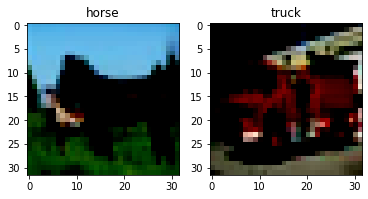

In [5]:
def visualize_image(train_idx: int, test_idx: int):
    """
    Function to visualize the images and labels given an sample number as index in train and test set
    
    Parameters:
    -----------
    train_idx: integer
    test_idx: integer
        
    """
    img1, label1 = trainset[train_idx]
    img2, label2 = testset[test_idx]
    print('Shape of single image: ', img1.shape)
    plt.subplot(121)
    plt.imshow(img1.permute((1, 2, 0)))
    plt.title(CLASSES[label1])
    plt.subplot(122)
    plt.imshow(img2.permute((1, 2, 0)))
    plt.title(CLASSES[label2])
    plt.show()

if VISUALIZE:
    visualize_image(12, 23)
    

                      

In [6]:
if torch.cuda.is_available():
    device_under_use = torch.device("cuda")
else:
    device_under_use = torch.device("cpu")
print(device_under_use)

cuda


In [7]:
# Get PyTorch train and validation samplers
def split(dataset: torch.utils.data.Dataset, 
          train_data_ratio: float = 0.7,
          shuffle: bool = True,
          random_seed: int = 0,
         ) -> typing.Tuple[SubsetRandomSampler, SubsetRandomSampler]:
    """
    Function to split train set into train & valid SubsetRandomSamplers.
    This doesnot return in 2 seperate torch.utils.data.Dataset() classes but returns 2 different Samplers.
    
    Parameters:
    -----------
    dataset: torch.utils.data.Dataset()
        Train set of CIFAR 10
    train_data_ratio: float
        Train data ratio, should be <1.0
    shuffle: bool
        Whether the output samplers will be shuffled or not.
    random_seed: int
        For setting np.random.seed() for shuffling (if shuffle==True)
    
    Return:
    -------
    train_sampler, valid_sampler, test_sampler: Tuple[SubsetRandomSampler, SubsetRandomSampler, SubsetRandomSampler]
        Individual samplers for train, validation and test data.
    """

    num_data = len(dataset)
    indices = list(range(num_data))
    split_train = int(np.floor(train_data_ratio * num_data))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx= (
        indices[:split_train],
        indices[split_train:],
    )

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    return train_sampler, valid_sampler

In [8]:
def get_train_valid_test_loader(train_dataset: torch.utils.data.Dataset,
                                test_dataset: torch.utils.data.Dataset,
                                train_batch_size: int = 8,
                                val_batch_size: int = 8,
                                test_batch_size: int = 8,
                                random_seed: int = 0,
                                shuffle: bool = True,
                                num_workers: int = 0,
                                pin_memory: bool = True,
                               ) -> typing.Tuple[torch.utils.data.DataLoader,
                                                 torch.utils.data.DataLoader, 
                                                 torch.utils.data.DataLoader,
                                                ]:
    """
    Parameters:
    -----------
    train_dataset: torch.utils.data.Dataset()
        Train set
    test_dataset: torch.utils.data.Dataset()
        Train set
    batch_size: int
        Batch size for training. The loader provides batch_size number of samples for each training time step.
    random_seed: int
        For setting np.random.seed() for shuffling (if shuffle==True)
    shuffle: bool
        If set true, the data is shuffled before sampling
    num_workers:: int
        How many subprocesses to use for data loading. 0 means the data will be loaded in the main process only.
    pin_memory: bool
        Decided whether data loader should copy the Tensors into CUDA pinned memory.
    
    Return:
    -------
    train_loader, valid_loader, test_loader:
        Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader, torch.utils.data.DataLoader]
        DataLoader for each sets of data.
    """

    
    # get train, validation and test samplers
    train_sampler, valid_sampler= split(
        train_dataset,
        train_data_ratio=0.7,
        shuffle=shuffle,
        random_seed=random_seed,
    )
    
    # load dataset
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    valid_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=val_batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=test_batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, valid_loader, test_loader

In [9]:
def accuracy_metric(Y: np.ndarray,
                    predictions: np.ndarray,
                   ) -> float:
    """
    Parameters:
    -----------
    Y: np.ndarray
        True labels in the test set
    predictions: np.ndarray
        Predictions on MNIST test set using the trained 2-layer NN
        
    Return:
    -------
    accuracy: float
        Accuracy metric on the Y and predictions provided to the function 
    
    """
    correct = 0
    for i in range(len(Y)):
        if Y[i] == predictions[i]:
            correct += 1
    accuracy = correct / float(len(Y)) * 100.0
    return accuracy

def metrics(Y: np.ndarray,
            predictions: np.ndarray,
            print_metrics: bool = False) -> typing.Tuple:
    """
    Calculates the accuracy and prints the confusion matrix for the true labels and predictions provided
    Parameters:
    -----------
    Y: np.ndarray
        True labels in the test set
    predictions: np.ndarray
        Predictions on MNIST test set using the trained 2-layer NN
    print_metrics: bool
        Flag to allow printing of the metrics calculated
    
    Return:
    -------
    accuracy: float
        Accuracy for the labels and predictions provided
    df_confusion: pandas dataframe
        Confusion matrix for the labels and predictions provided
        
    """
    accuracy = accuracy_metric(Y, predictions)
    df_confusion = pd.crosstab(Y, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    if print_metrics:
        print("Accuracy: ", accuracy)
        print("Confusion matrix: \n", df_confusion)
        
    return accuracy, df_confusion


In [10]:
def validation(valid_loader: torch.utils.data.DataLoader, 
               model: torch.nn,
              ) -> typing.Tuple:
    
    """
    Validation module
    
    Parameters:
    -----------
    valid_loader: torch.utils.data.DataLoader
        Validation data loader
    model: torch.nn
        Model
    
    Return:
    -------
    avg_val_loss: float
        Validation loss for 1 full pass of the validation data
        
    avg_val_accuracy: float
        Validation accuracy for 1 full pass of the validation data
    
    """
    
    model.train(False)
    criterion = nn.CrossEntropyLoss().to(device_under_use)
    
    valid_len = len(valid_loader.batch_sampler)
    av_loss = 0
    av_accuracy = 0
    y_pred = []
    y_true = []
    
    for images, labels in valid_loader:
    
        images = images.view(-1, 3* 32 * 32).to(device_under_use)
        labels = labels.to(device_under_use)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        av_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        
        labels_list = labels.tolist()
        y_true.extend(labels_list)
        
        accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred))
        av_accuracy += accuracy
    
    avg_val_loss = av_loss / valid_len
    avg_val_accuracy = av_accuracy / valid_len
    
    return avg_val_loss, avg_val_accuracy
    

In [11]:
def evaluation(test_loader:  torch.utils.data.DataLoader,
               model: torch.nn,
              ) -> typing.Tuple:
    
    """
    Testing module
    
    Parameters:
    -----------
    test_loader:  torch.utils.data.DataLoader
        Validation data loader
    model: torch.nn
        Model
    
    Return:
    -------
    avg_test_loss: float
        Average loss for the test set
    accuracy: float
        Accuracy for the labels and predictions provided
    df_confusion: pandas dataframe
        Confusion matrix for the labels and predictions provided
        
    """
    
    model.eval()
    
    test_len = len(test_loader.batch_sampler)
    print('Size of test data: ', test_len)
    
    test_loss = 0
    confusion_matrix = np.zeros((11, 11))
    accuracy_list = []
    y_pred = []
    y_true = []
    
    criterion = nn.CrossEntropyLoss().to(device_under_use)
    
    for images, labels in test_loader:
    
        images = images.view(-1, 3* 32 * 32).to(device_under_use)
        labels = labels.to(device_under_use)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        test_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        
        labels_list = labels.tolist()
        y_true.extend(labels_list)
        
    accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred), True)
    avg_test_loss = test_loss / test_len
    return avg_test_loss, accuracy, df_confusion

In [12]:
def plot_training_graph(train_data: typing.List, 
                        val_data: typing.List,
                        label: bool):
    
    """
    Visualize the training/validation loss/accuracy of the model
    
    Parameters:
    -----------
    train_data: typing.List
        Train loss/accuracy per epoch
    val_data: typing.List,
        Validation loss/accuracy per epoch
    label: bool
        Flag stating whether loss/accuracy
    
    """
    if label == 'accuracy':
        train_label = 'Training accuracy'
        val_label = 'Validation accuracy'
        x_label = 'Epoch'
        y_label = 'Accuracy'
        title = 'Epoch vs Accuracy'
    else:
        train_label = 'Training loss'
        val_label = 'Validation loss'
        x_label = 'Epoch'
        y_label = 'Loss'
        title = 'Epoch vs Loss'
    plt.figure(figsize=(12,12))
    plt.plot(train_data, c='k', label=train_label)
    plt.plot(val_data, c='m', label=val_label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
def get_gradients(named_parameters: typing.Generator) -> typing.List:
    
    """
    Parameters:
    -----------
    named_parameters: typing.Generator 
        model layer names and tensor value
    
    Return:
    -------
    norm_grads: typing.List
        List of gradient norms for all layers in the model named parameters
    
    """
    norm_grads = []
    layers = []
    for name, tensor_value in named_parameters:
        if tensor_value.requires_grad:
            layers.append(name)
            norm_grads.append(tensor_value.grad.abs().norm().item())
            
    return norm_grads

In [14]:
def plot_norm_grads(named_parameters: typing.Generator, 
                    norm_grads: typing.List):
    
    """
    Parameters:
    -----------
    named_parameters: typing.Generator 
        model layer names and tensor value
    
    norm_grads: typing.List
        List of gradient norms for all layers in the model named parameters
    
    """
    norm_grads_array = np.array(norm_grads)
    
    plots_per_row = 2
    rows = int(norm_grads_array.shape[1] / plots_per_row) 
    columns = min(norm_grads_array.shape[1], plots_per_row)
    remaining = (norm_grads_array.shape[1] - (rows * columns))
    if remaining:
        rows = rows + 1
        
    fig, axs = plt.subplots(rows, columns, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.suptitle("Layer-wise gradient norm")
    fig.subplots_adjust(left=0.125, bottom=0.2, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
    
    layers = []
    for name, tensor_value in named_parameters:
        if tensor_value.requires_grad:
            layers.append(name)

    axs = axs.flatten()
    for i, ax in enumerate(axs):
        ax.plot(norm_grads_array[:, i])
        ax.set_title(layers[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Gradient norm')
        
    plt.show()

In [15]:
def trainer(train_loader: torch.utils.data.DataLoader,
            valid_loader: torch.utils.data.DataLoader,
            model: torch.nn,
            num_epochs: int,
            learning_rate: float,
            patience: int,
            plot_gradients: bool = True,
           ) -> typing.Tuple:
    
    """
    Parameters:
    -----------
    train_loader: torch.utils.data.DataLoader
        Train data loader
    valid_loader: torch.utils.data.DataLoader
        Validation data loader
    model: torch.nn
        Classifier model
    num_epochs: int
        Maximum epoch limit
    learning_rate: float
        Learning rate for weight update
    patience: int
        Patience to trigger early stopping    
    plot_gradients: bool
        Flag to plot all the layer-wise weight gradients
        
    Return:
    -------
    best_model: torch.nn
        Best model from training depending on the validation loss
    train_costs_per_epoch: List
        List containing loss on training data for each epoch
    val_costs_per_epoch: List
        List containing loss on validation data for each epoch
    train_accuracy_per_epoch: List
        List containing accuracy on training data for each epoch
    val_accuracy_per_epoch: List
        List containing loss on validation data for each epoch
    
    """
    
    # num_epochs = int(n_iters/(len(train_loader.batch_sampler)))
    patience_count = patience
    criterion = nn.CrossEntropyLoss().to(device_under_use)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    best_validation_loss = np.inf
    train_costs_per_epoch = []
    val_costs_per_epoch = []
    best_model = model
    norm_grads = []
    train_accuracy_per_epoch = []
    val_accuracy_per_epoch = []
    
    for epoch in range(num_epochs):

        running_train_loss = []
        running_norm_grads = []
        running_train_accuracy = []
        y_pred = []
        y_true = []
        
        model.train(True)

        for images, labels in train_loader:

            images = images.view(-1, 3* 32 * 32).to(device_under_use)
            labels = labels.to(device_under_use)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_train_loss.append(loss.detach().item())
            loss.backward()
            running_norm_grads.append(get_gradients(model.named_parameters()))
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.tolist())
        
            labels_list = labels.tolist()
            y_true.extend(labels_list)
        
            accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred))
            running_train_accuracy.append(accuracy)

        avg_train_loss = sum(running_train_loss) / len(running_train_loss)
        train_costs_per_epoch.append(avg_train_loss)

        avg_val_loss, avg_val_accuracy = validation(valid_loader, model)
        val_costs_per_epoch.append(avg_val_loss)
        val_accuracy_per_epoch.append(avg_val_accuracy)
        
        norm_grads_avg = list(np.mean(np.array(running_norm_grads), axis=0))
        norm_grads.append(norm_grads_avg)
        
        avg_train_accuracy = sum(running_train_accuracy) / len(running_train_accuracy)
        train_accuracy_per_epoch.append(avg_train_accuracy)
    
        # Early stopping: Waits up to the 'patience' number of epochs for a better model
        # If a better model is not found for the 'patience' number of epochs then training stops
        # To avoid overfitting of the model to the train set
        
        if avg_val_loss < best_validation_loss:
            best_validation_loss = avg_val_loss
            best_model = model
            patience_count = patience
            print("Better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))
        else:
            patience_count = patience_count - 1
            print("No better model found: Epoch: %i -- Train loss: %f -- Validation loss: %f"%(epoch + 1, avg_train_loss, avg_val_loss))

        if patience_count == 0:
            print("Early stopping triggered: Epoch: %i -- Train loss: %f -- Validation loss: %f" %(epoch + 1, avg_train_loss, avg_val_loss))
            break   
    
    if plot_gradients:
        plot_norm_grads(model.named_parameters(), norm_grads)
        
    return best_model, train_costs_per_epoch, val_costs_per_epoch, train_accuracy_per_epoch, val_accuracy_per_epoch

In [16]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units=300, activation_function="SIGMOID"):
        super(LogisticRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_units)
        self.linear2 = nn.Linear(hidden_units, output_dim)
        self.relu = nn.ReLU()
        if activation_function == "RELU":
            self.activation = self.relu
        elif activation_function == "SIGMOID":
            self.activation = nn.Sigmoid()
        elif activation_function == "SOFTMAX":
            self.activation = nn.Softmax(dim=1)
     
    def forward(self, x):
        out = self.relu(self.linear1(x))
        out = self.activation(self.linear2(out))
        return out

In [17]:
def CIFAR10_classifier(learning_rate: float,
                       train_batch_size: int,
                       patience: int,
                       activation_function: str,
                       num_epochs: int,
                       hidden_units: int,
                      ) -> typing.Tuple:
    
    """
    Function performing the classification on CIFAR10
    
    Parameters:
    -----------
    learning_rate: float
        Learning rate for weight update
    train_batch_size: int
        Batch size of train loader
    patience: int
        Patience to trigger early stopping   
    activation_function: str
        Activation function
    num_epochs: int
        Maximum epoch limit
    hidden_units: int
        Number of hidden units in the hidden layer
        
    Return:
    -------
    best_model: torch.nn
        Best model from training depending on the validation loss
    accuracy: float
        Accuracy for the labels and predictions provided
    
    """
    
    # Hyperparameters
    learning_rate = learning_rate
    train_batch_size = train_batch_size
    patience = patience
    activation_function = activation_function
    num_epochs = num_epochs
    hidden_units = hidden_units
    
    # Fixed parameters
    val_batch_size = 100
    test_batch_size = 8
    input_dim = 3 * 32 * 32
    output_dim = 10
    
    print("\n")
    print("##### Statistics of the run #####")
    print("Learning rate: ", learning_rate)
    print("Batch size for training: ", train_batch_size)
    print("Patience for early stopping: ", patience)
    print("Activation function: ", activation_function)
    print("Num epochs: ", num_epochs)
    
    train_loader, valid_loader, test_loader = get_train_valid_test_loader(train_dataset=trainset,
                                                                          test_dataset=testset,
                                                                          train_batch_size=train_batch_size,
                                                                          val_batch_size=val_batch_size,
                                                                          test_batch_size=test_batch_size,
                                                                          random_seed=0,
                                                                          shuffle=True,
                                                                          num_workers=0,
                                                                          pin_memory=True,
                                                                         )
    print("Number of train batches: ", len(train_loader.batch_sampler))
    print("Number of validation batches: ", len(valid_loader.batch_sampler))
    print("Number of test batches: ", len(test_loader.batch_sampler))
    print("\n")
    print("##### Training module #####")
    model = LogisticRegressionModel(input_dim, output_dim, hidden_units, activation_function).to(device_under_use)

    best_model, train_costs_per_epoch, val_costs_per_epoch, \
    train_accuracy_per_epoch, val_accuracy_per_epoch = trainer(train_loader=train_loader,
                                                                     valid_loader=valid_loader,
                                                                     model=model,
                                                                     num_epochs=num_epochs,
                                                                     learning_rate=learning_rate,
                                                                     patience=patience,
                                                                    )
    plot_training_graph(train_costs_per_epoch, val_costs_per_epoch, 'loss')
    plot_training_graph(train_accuracy_per_epoch, val_accuracy_per_epoch, 'accuracy')
    print("\n")
    print("##### Evaluation module #####")
    avg_test_loss, accuracy, df_confusion = evaluation(test_loader, best_model)
    print("\n")
    return best_model, accuracy




##### Statistics of the run #####
Learning rate:  0.001
Batch size for training:  100
Patience for early stopping:  5
Activation function:  SOFTMAX
Num epochs:  50
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250


##### Training module #####
Better model found: Epoch: 1 -- Train loss: 2.301041 -- Validation loss: 2.300134
Better model found: Epoch: 2 -- Train loss: 2.299116 -- Validation loss: 2.298182
Better model found: Epoch: 3 -- Train loss: 2.297052 -- Validation loss: 2.296078
Better model found: Epoch: 4 -- Train loss: 2.294820 -- Validation loss: 2.293791
Better model found: Epoch: 5 -- Train loss: 2.292383 -- Validation loss: 2.291273
Better model found: Epoch: 6 -- Train loss: 2.289689 -- Validation loss: 2.288460
Better model found: Epoch: 7 -- Train loss: 2.286674 -- Validation loss: 2.285299
Better model found: Epoch: 8 -- Train loss: 2.283301 -- Validation loss: 2.281766
Better model found: Epoch: 9 -- Train loss: 2.279577 

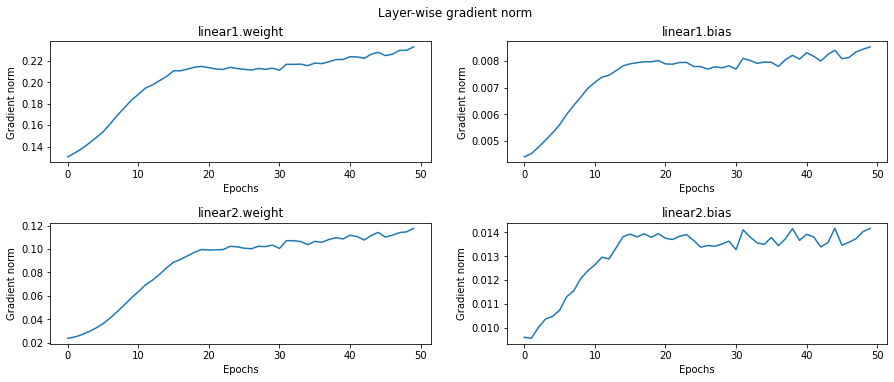

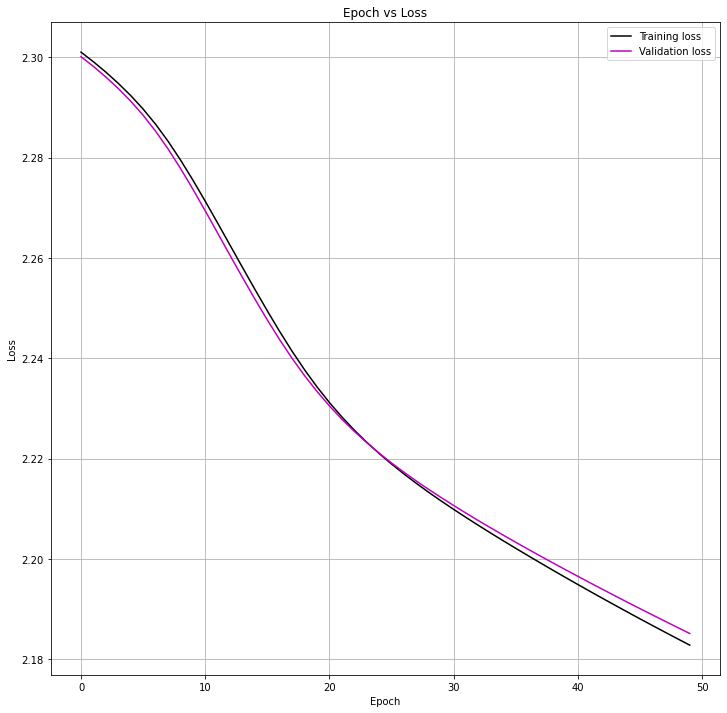

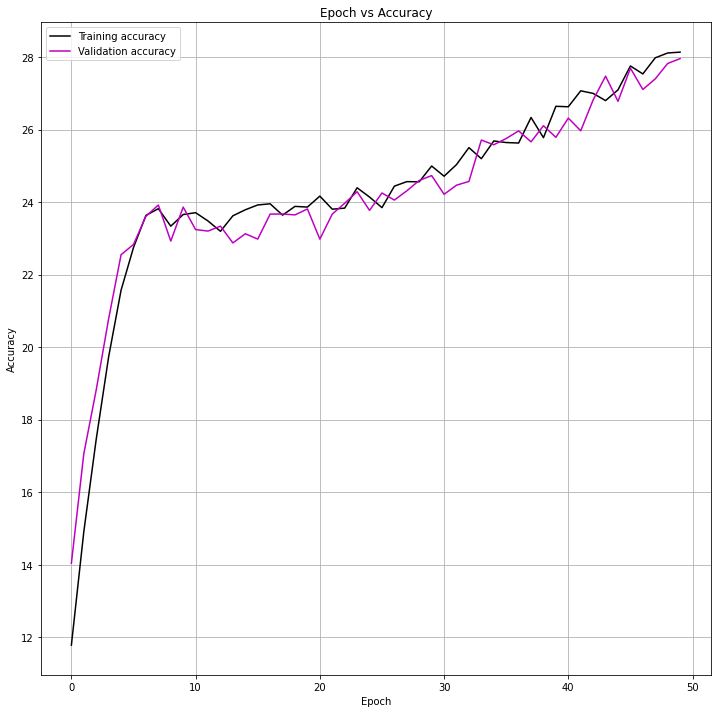



##### Evaluation module #####
Size of test data:  1250
Accuracy:  28.660000000000004
Confusion matrix: 
 Predicted     0    1    4     5     6   7     8     9    All
Actual                                                      
0           456   17   25    20    75   0   283   124   1000
1            61   73   38    60   224   0   175   369   1000
2           190    7   89    66   425   3    97   123   1000
3           118    8  104   211   325   2    44   188   1000
4            84    2  161    73   503   2    57   118   1000
5            98    3   91   326   272   2    86   122   1000
6            76    1   55    72   646   2    15   133   1000
7            98   11  170    91   226   7    88   309   1000
8            79   16   19    81    35   1   585   184   1000
9            56   17   26    23   105   0   161   612   1000
All        1316  155  778  1023  2836  19  1591  2282  10000




In [27]:
model, accuracy = CIFAR10_classifier(0.001, 100, 5, "SOFTMAX", 50, 100)

In [19]:
# SMAC - Sequential Model-based Algorithm Configuration
import smac

# Import ConfigSpace and different types of parameters
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter


from smac.configspace import ConfigurationSpace

from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.scenario.scenario import Scenario
from smac.initial_design.default_configuration_design import DefaultConfiguration

In [20]:
def define_search_space():
    """
    Build Configuration Space which defines all hyperparameters and their ranges
    
    Return:
    -------
    cs: ConfigurationSpace
        Configuration space with all hyperparameters of the classifier selected for HPO
    """
    
    cs = ConfigurationSpace()
    # constraining the parameter search space to curtail the train time
    learning_rate = UniformFloatHyperparameter("learning_rate", 0.001, 0.01, default_value=0.001)
    #train_batch_size = CategoricalHyperparameter("train_batch_size", [8, 32, 100], default_value=8)
    activation_function = CategoricalHyperparameter("activation_function", ["RELU", "SIGMOID", "SOFTMAX"], default_value="SIGMOID")
    #num_epochs = CategoricalHyperparameter("num_epochs", [10, 100, 150], default_value=100)
    hidden_units = CategoricalHyperparameter("hidden_units", [100, 300, 500], default_value=300)
    cs.add_hyperparameters([learning_rate, activation_function, hidden_units])
    
    return cs

def run_model_from_cfg(cfg):
    """
    Target algorithm wrapper evaluated by the SMAC as an objective function.
    In our case, the objective function is NN performing classification on CIFAR10 dataset
    
    Parameters:
    -----------
    cfg: Configuration
        One single configuration to be tested on the target algorithm by SMAC
        
    Return:
    -------
    accuracy: float
        Accuracy of the model on the CIFAR10 test set
        -ve value is returned as the result of evaluation because
        SMAC performs minimization of the cost function
    """
    print("##### Configuration #####")
    print(cfg)
    cfg = {k: cfg[k] for k in cfg if cfg[k]}
    cfg["patience"] = 5
    cfg["num_epochs"] = 10
    cfg["train_batch_size"] = 100
    model, accuracy = CIFAR10_classifier(**cfg)
    return -accuracy

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2020-11-27_10:21:50_138723
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.default_configuration_design.DefaultConfiguration:Running initial design for 2 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


##### Configuration #####
Configuration:
  activation_function, Value: 'SIGMOID'
  hidden_units, Value: 300
  learning_rate, Value: 0.001



##### Statistics of the run #####
Learning rate:  0.001
Batch size for training:  100
Patience for early stopping:  5
Activation function:  SIGMOID
Num epochs:  10
Number of train batches:  350
Number of validation batches:  150
Number of test batches:  1250


##### Training module #####
Better model found: Epoch: 1 -- Train loss: 2.298486 -- Validation loss: 2.292752
Better model found: Epoch: 2 -- Train loss: 2.287369 -- Validation loss: 2.282063
Better model found: Epoch: 3 -- Train loss: 2.276690 -- Validation loss: 2.271784
Better model found: Epoch: 4 -- Train loss: 2.266379 -- Validation loss: 2.261882
Better model found: Epoch: 5 -- Train loss: 2.256451 -- Validation loss: 2.252383
Better model found: Epoch: 6 -- Train loss: 2.246933 -- Validation loss: 2.243317
Better model found: Epoch: 7 -- Train loss: 2.237863 -- Validation loss: 2.234

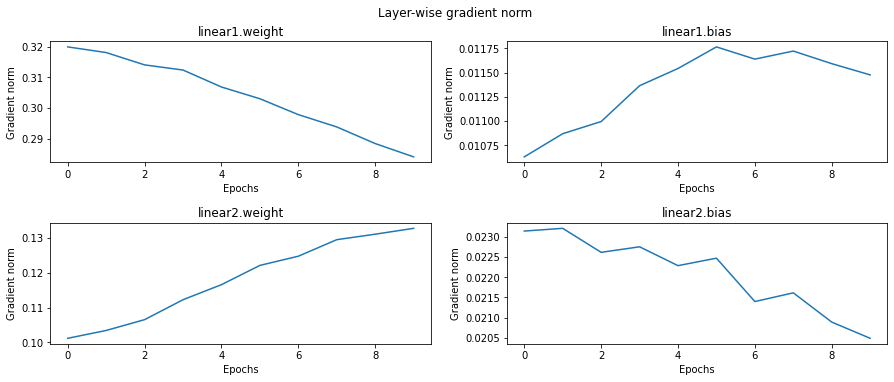

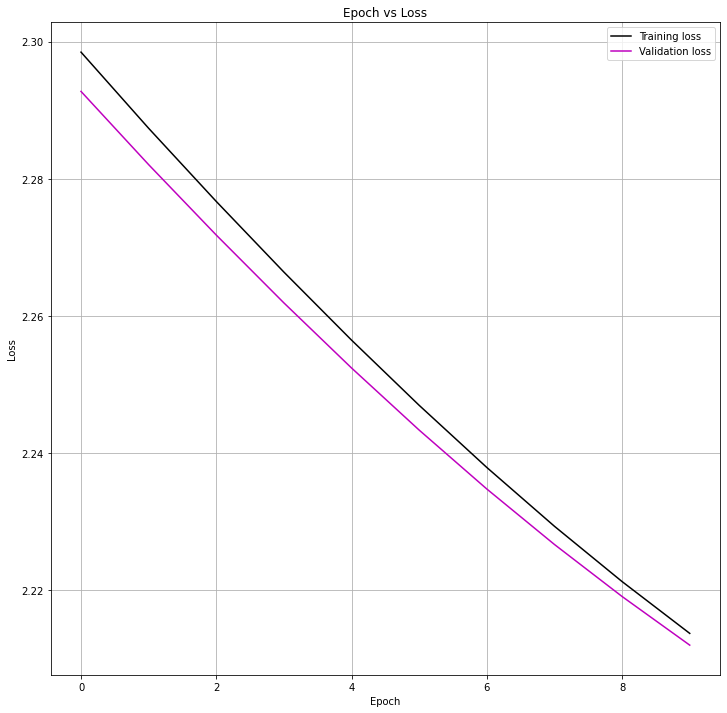

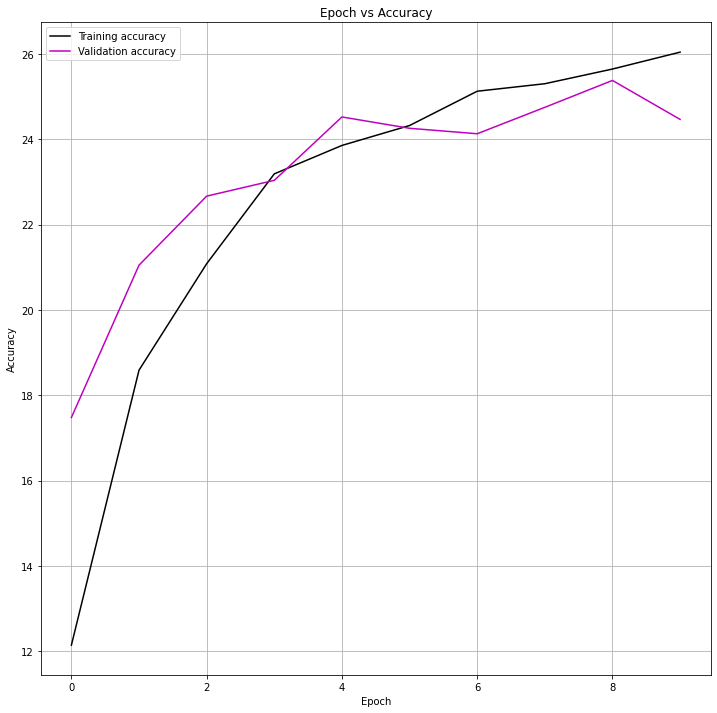



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: -25.9300


Accuracy:  25.929999999999996
Confusion matrix: 
 Predicted     0    1  2    3    4    5     6    7     8     9    All
Actual                                                              
0           462   26  1   14    1   27   115   21   201   132   1000
1            90   81  0    4    3   18   373   23   121   287   1000
2           221   14  0    7   15   54   468   65    60    96   1000
3           135   18  1   35    5  118   454   61    28   145   1000
4            90   11  2   16   24   65   586   67    37   102   1000
5           121    8  1   33   11  206   398   67    58    97   1000
6            88    6  2    6    5   48   678   53    12   102   1000
7           104   11  0   22   29   64   320  129    56   265   1000
8           109   34  0    4    4   55   111    8   450   225   1000
9            89   26  0    5    4   13   173   28   134   528   1000
All        1509  235  7  146  101  668  3676  522  1157  1979  10000


##### Configuration #####
Configuration:
  activati

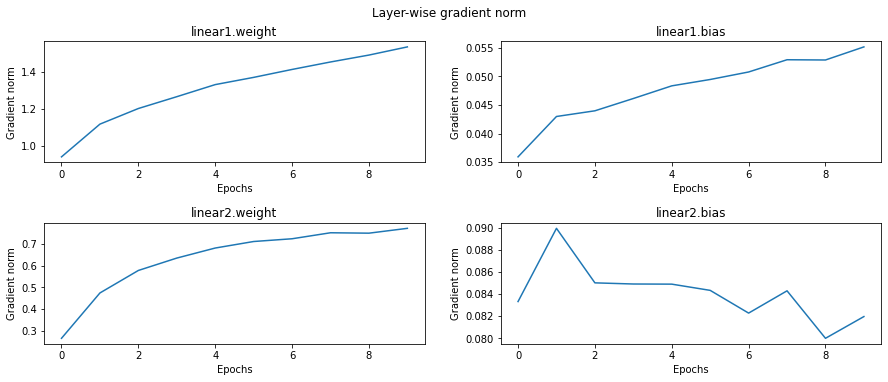

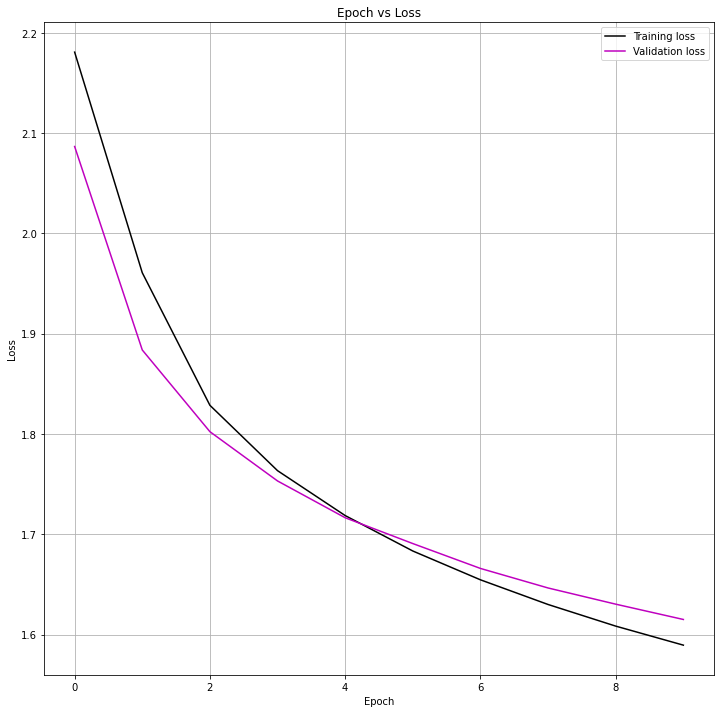

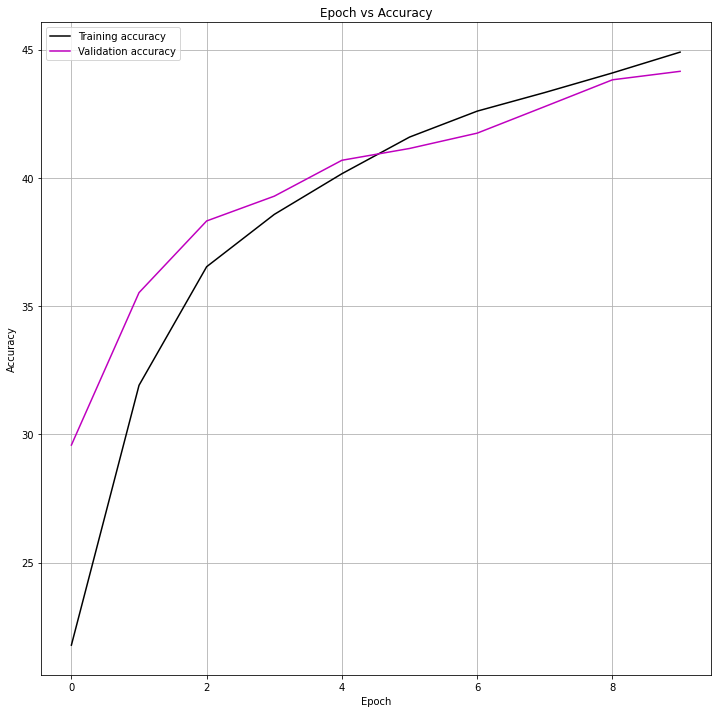



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Challenger (-44.3900) is better than incumbent (-25.9300) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  activation_function : 'SIGMOID' -> 'RELU'
INFO:smac.intensification.intensification.Intensifier:  hidden_units : 300 -> 100
INFO:smac.intensification.intensification.Intensifier:  learning_rate : 0.001 -> 0.006051472744188423
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 925.978975 sec, available: 0.000010 sec)


Accuracy:  44.39
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          478    59   48   25   23   20    27    45   204    71   1000
1           33   547   15   32   19   23    44    41    85   161   1000
2           91    36  289   82  109   84   170    82    31    26   1000
3           32    47   75  274   49  191   144    85    35    68   1000
4           50    32  146   48  318   59   179   108    29    31   1000
5           22    27   84  160   68  365   115    93    40    26   1000
6            9    40   69   72   85   72   578    29    12    34   1000
7           36    46   47   55   88   80    58   483    26    81   1000
8           91    92   17   17   16   32     8    27   607    93   1000
9           41   209   13   36   13   16    38    51    83   500   1000
All        883  1135  803  801  788  942  1361  1044  1152  1091  10000


##### Configuration #####

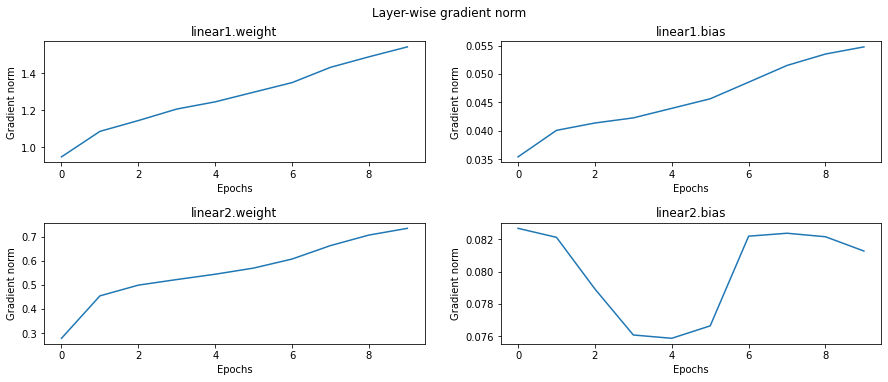

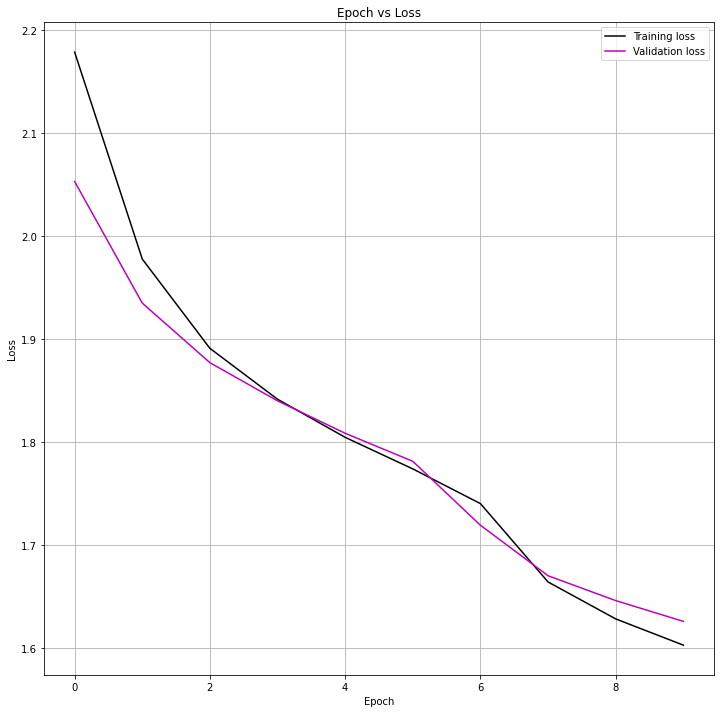

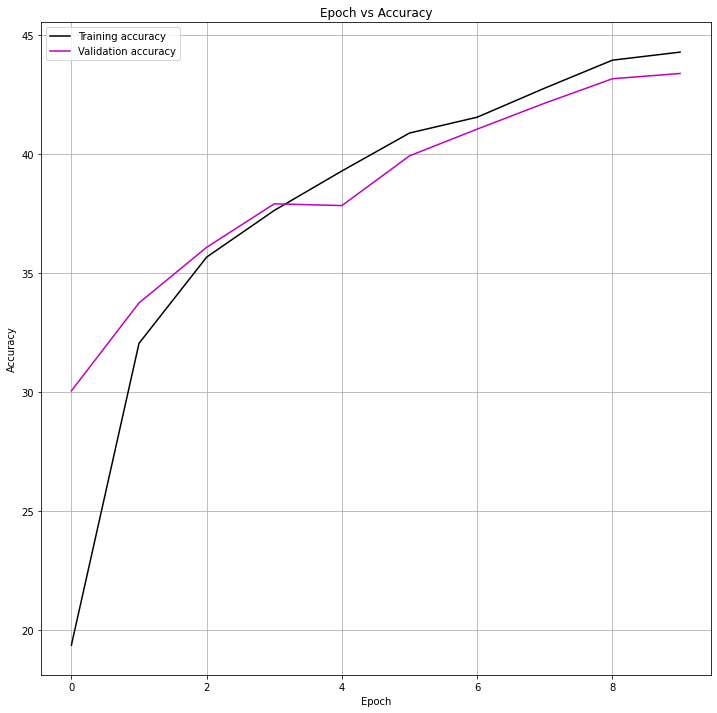



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 458.196959 sec, available: 0.000010 sec)


Accuracy:  44.25
Confusion matrix: 
 Predicted     0     1    2    3    4    5     6     7     8     9    All
Actual                                                                  
0           524    56   53   27    9   18    33    53   167    60   1000
1            45   572   16   36   20   24    48    31    58   150   1000
2            91    34  323   99   66   63   166    99    32    27   1000
3            43    47   75  324   28  155   148    86    33    61   1000
4            62    32  163   59  223   52   207   155    24    23   1000
5            29    27   91  199   37  330   122   104    42    19   1000
6            10    32   84  106   48   55   584    36    10    35   1000
7            43    37   45   66   75   68    65   494    24    83   1000
8           133   101   13   21    8   30     9    26   565    94   1000
9            59   224   15   28    7   15    42    63    61   486   1000
All        1039  1162  878  965  521  810  1424  1147  1016  1038  10000


##### Config

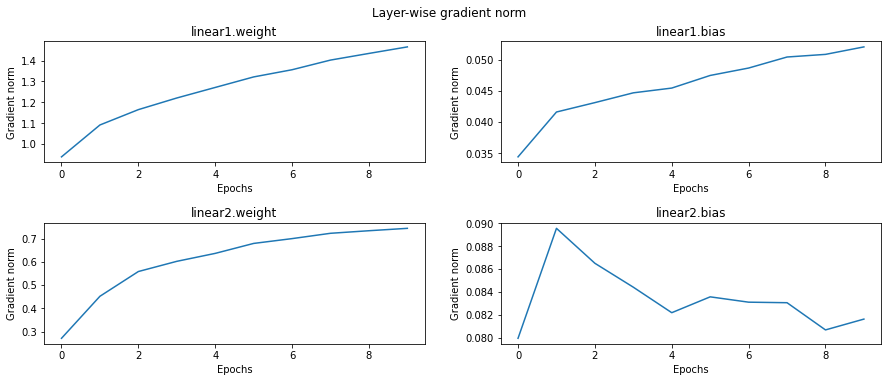

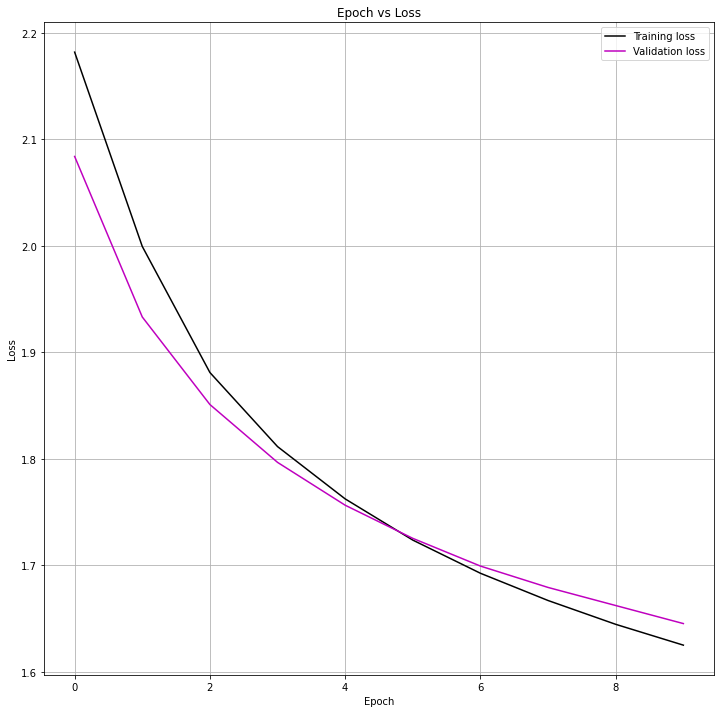

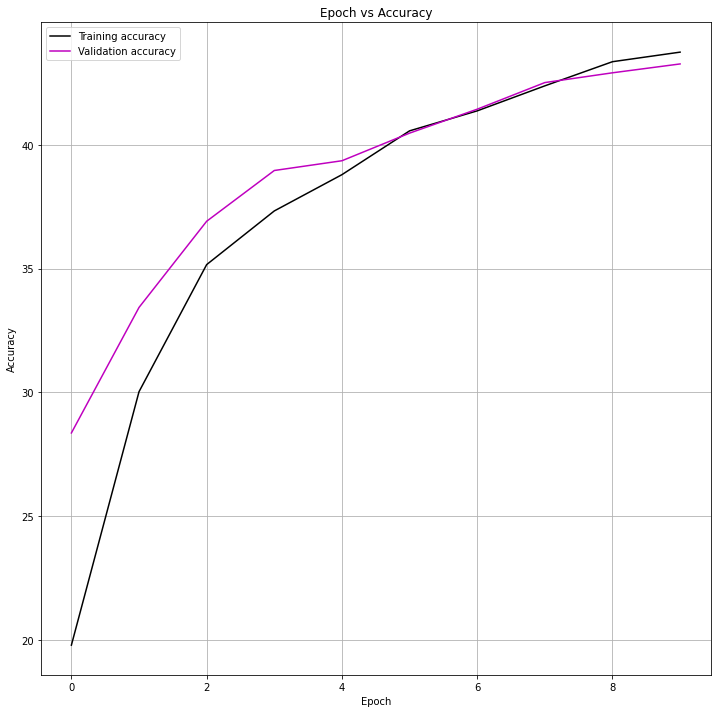



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 459.251646 sec, available: 0.000010 sec)


Accuracy:  43.669999999999995
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          490    42   59   27   12   16    29    51   218    56   1000
1           35   513   20   39   17   25    42    45   104   160   1000
2          108    32  314   89   95   56   150    95    33    28   1000
3           37    54   89  316   40  140   131    94    39    60   1000
4           53    30  178   56  272   51   171   131    33    25   1000
5           23    29  102  203   45  299   113   113    51    22   1000
6           11    38   92   99   69   53   557    35    10    36   1000
7           42    45   57   53   68   59    57   519    27    73   1000
8          102    86   17   31    8   20     8    33   606    89   1000
9           49   190   11   35   12   14    39    61   108   481   1000
All        950  1059  939  948  638  733  1297  1177  1229  1030  10000


##### Config

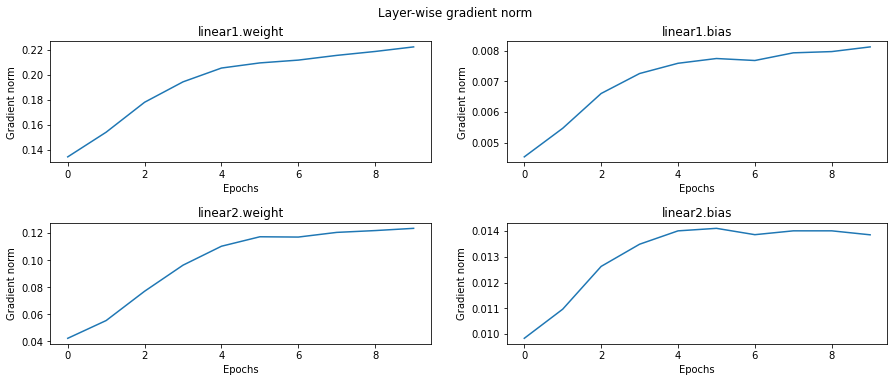

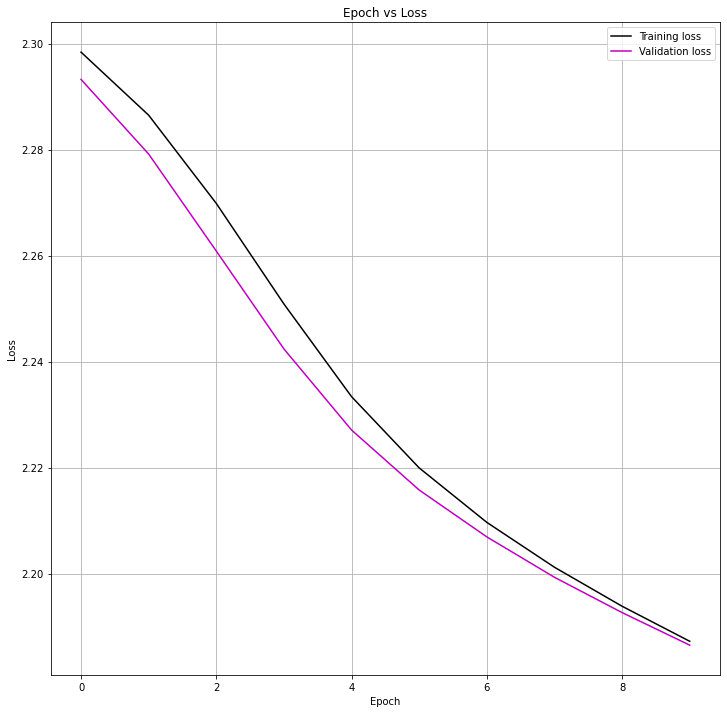

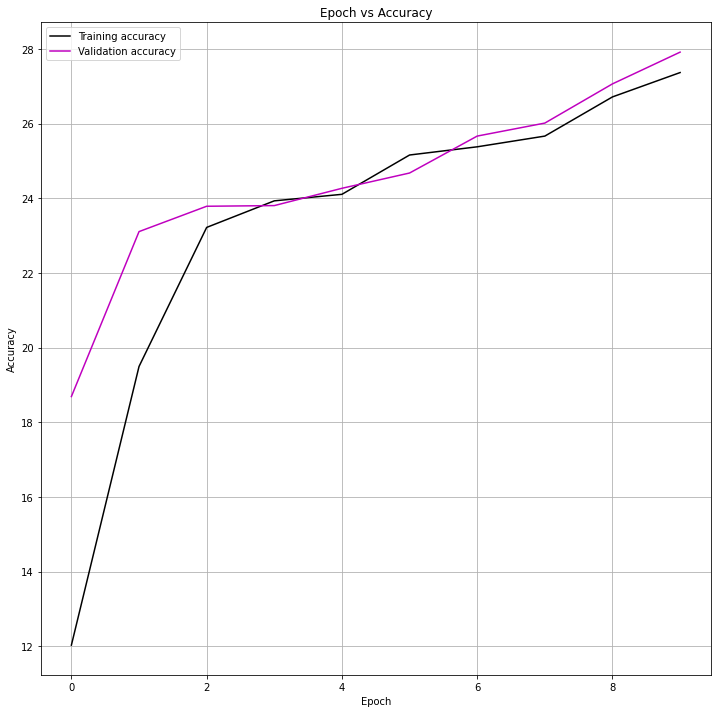



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 462.787297 sec, available: 0.000010 sec)


Accuracy:  28.13
Confusion matrix: 
 Predicted     0   1  2  3    4     5     6   7     8     9    All
Actual                                                           
0           459   1  0  0   26    28    83   4   271   128   1000
1            56   8  0  1   40    53   274   2   166   400   1000
2           189   0  2  0   74   104   391   7    90   143   1000
3           109   0  2  0   97   241   309   6    42   194   1000
4            76   1  0  0  167    91   463   6    50   146   1000
5            97   0  0  1   82   352   257   6    72   133   1000
6            71   0  0  0   44    91   614   2    16   162   1000
7            91   0  1  0  152   109   215  16    84   332   1000
8            81   1  0  0   19    90    52   1   566   190   1000
9            53   1  0  0   27    25   110   1   154   629   1000
All        1282  12  5  2  728  1184  2768  51  1511  2457  10000


##### Configuration #####
Configuration:
  activation_function, Value: 'SOFTMAX'
  hidden_units, Value:

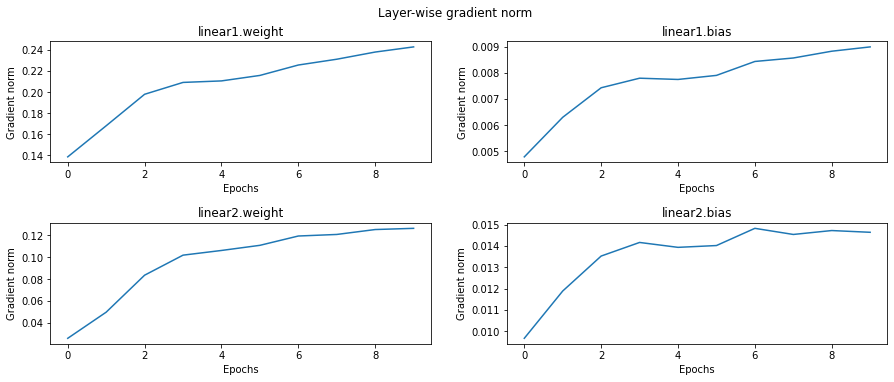

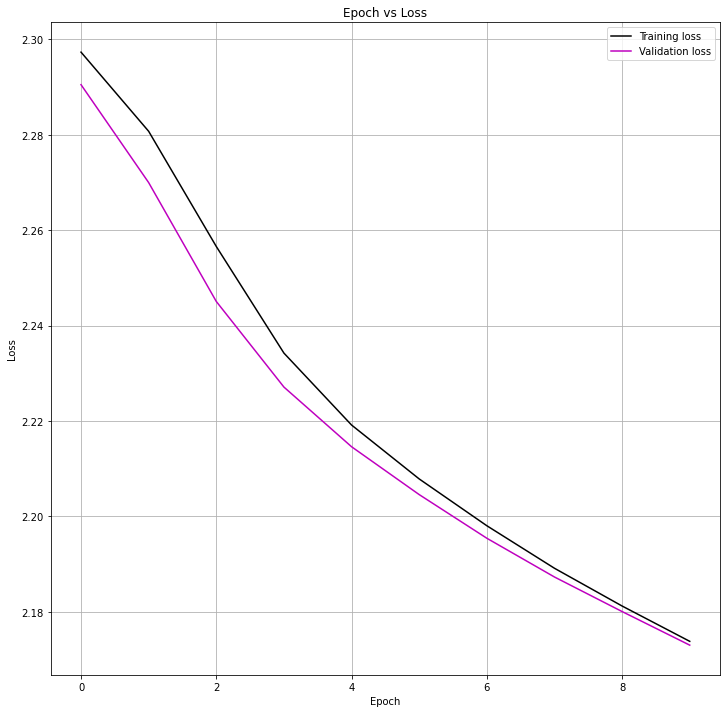

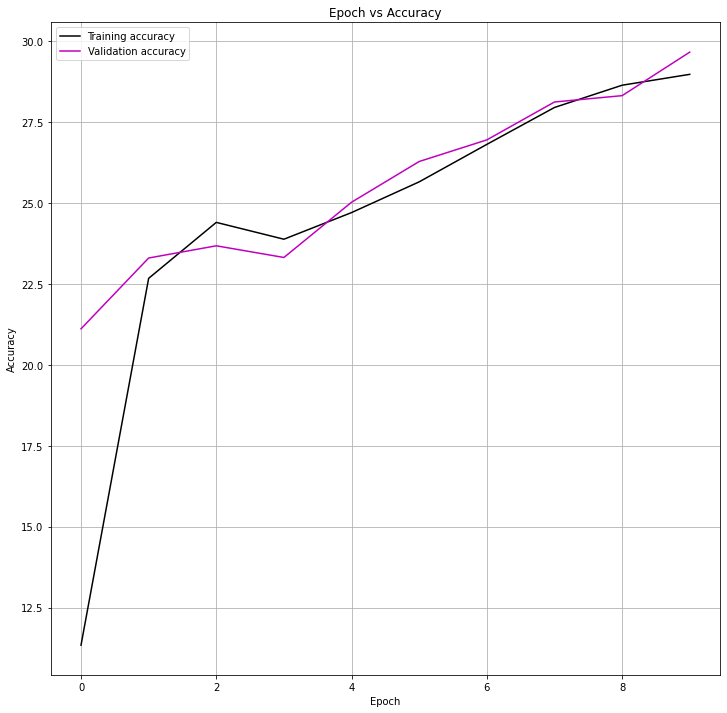



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 458.146909 sec, available: 0.000010 sec)


Accuracy:  30.06
Confusion matrix: 
 Predicted     0   1     4     5     6    7     8     9    All
Actual                                                       
0           452   6    20    25    75   30   278   114   1000
1            51  24    67    63   224   29   159   383   1000
2           174   1   140    80   341   82    85    97   1000
3           101   0   139   222   244  102    38   154   1000
4            64   1   262    65   376   88    55    89   1000
5            75   0   116   337   211   96    77    88   1000
6            55   0    74    83   584   83    14   107   1000
7            70   1   184    95   156  168    86   240   1000
8            84   1    29    83    41   10   577   175   1000
9            44   5    33    27   101   26   162   602   1000
All        1170  39  1064  1080  2353  714  1531  2049  10000


##### Configuration #####
Configuration:
  activation_function, Value: 'RELU'
  hidden_units, Value: 300
  learning_rate, Value: 0.006094089305626252



##

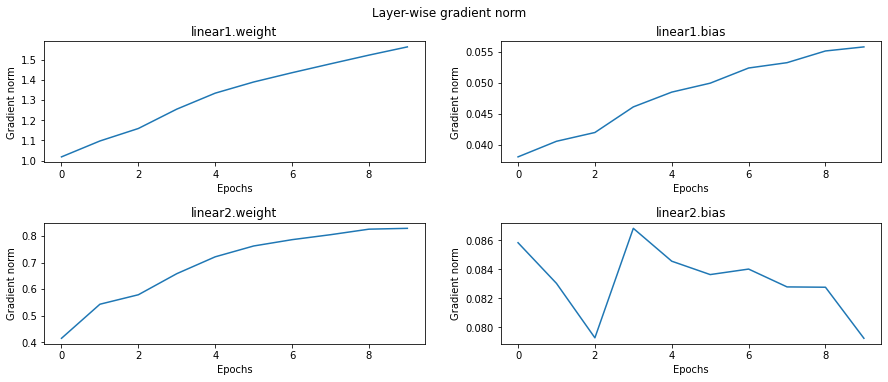

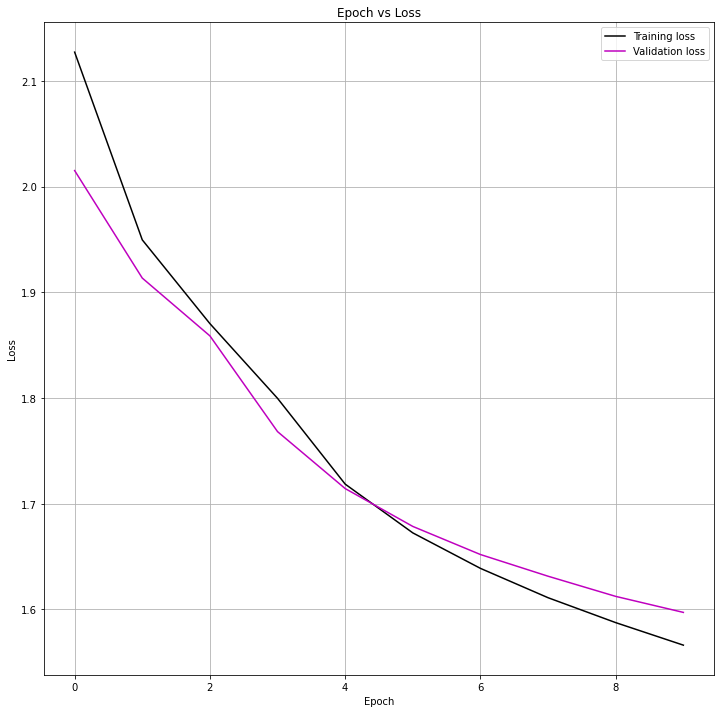

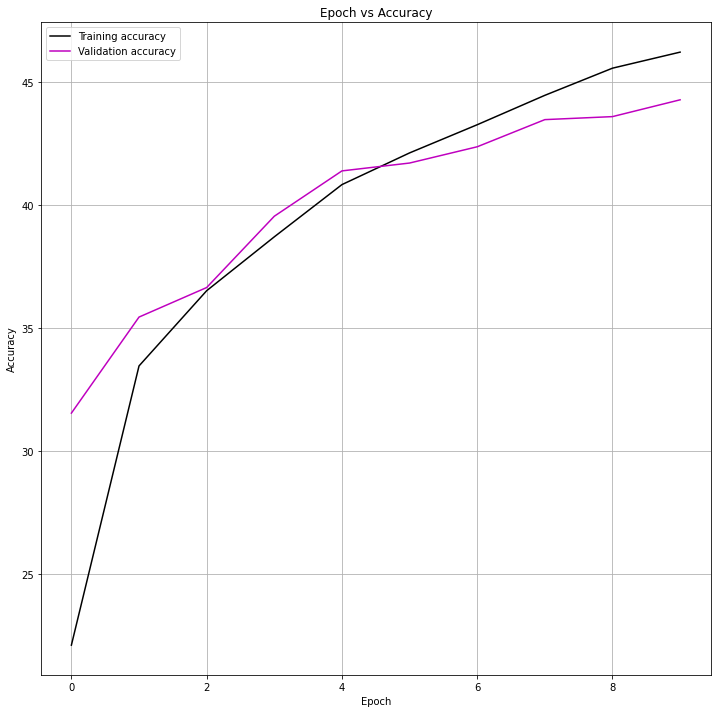



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Challenger (-45.3800) is better than incumbent (-44.3900) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  hidden_units : 100 -> 300
INFO:smac.intensification.intensification.Intensifier:  learning_rate : 0.006051472744188423 -> 0.006094089305626252
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 452.185882 sec, available: 0.000010 sec)


Accuracy:  45.379999999999995
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          485    55   56   28   20   15    28    43   212    58   1000
1           35   568   15   35   22   22    37    39    90   137   1000
2           91    39  306   94  123   73   140    77    34    23   1000
3           35    54   69  331   47  160   132    71    39    62   1000
4           55    35  141   55  343   60   155   103    27    26   1000
5           21    32   95  201   65  329    97    89    47    24   1000
6            9    38   73   95   96   70   543    30    12    34   1000
7           42    46   48   63   86   67    50   491    28    79   1000
8           84    92   16   26   15   29     6    20   641    71   1000
9           41   200   13   39   14   18    31    49    94   501   1000
All        898  1159  832  967  831  843  1219  1012  1224  1015  10000


##### Config

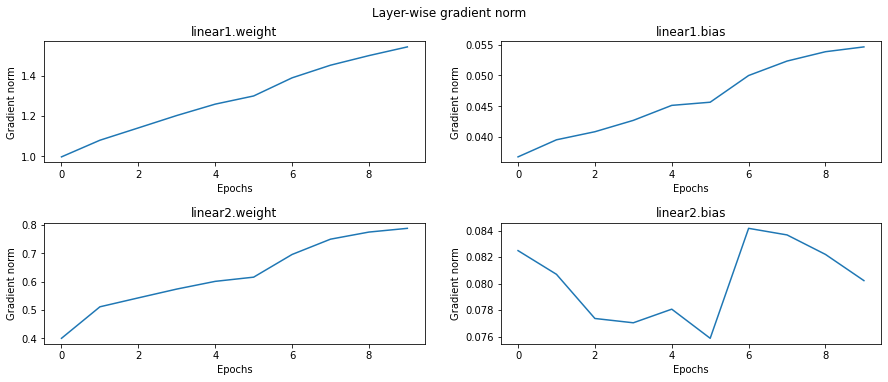

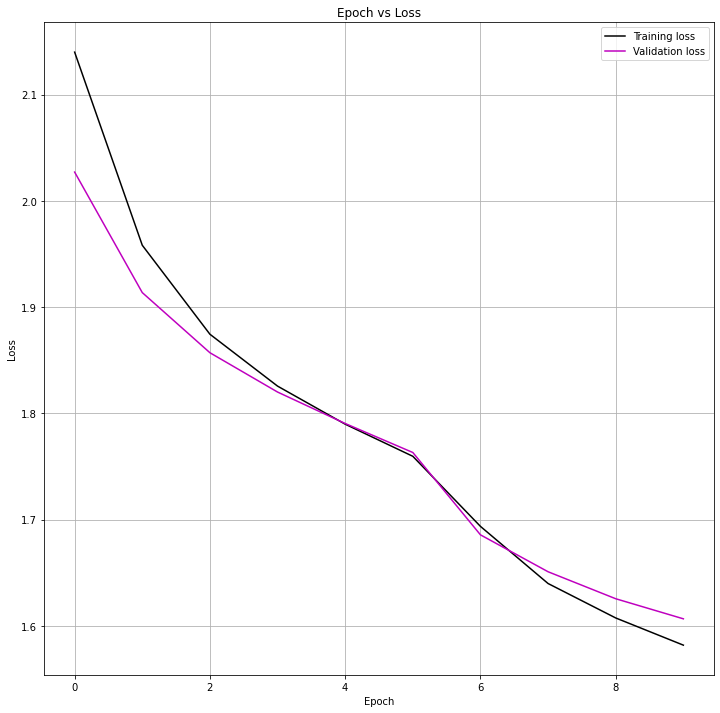

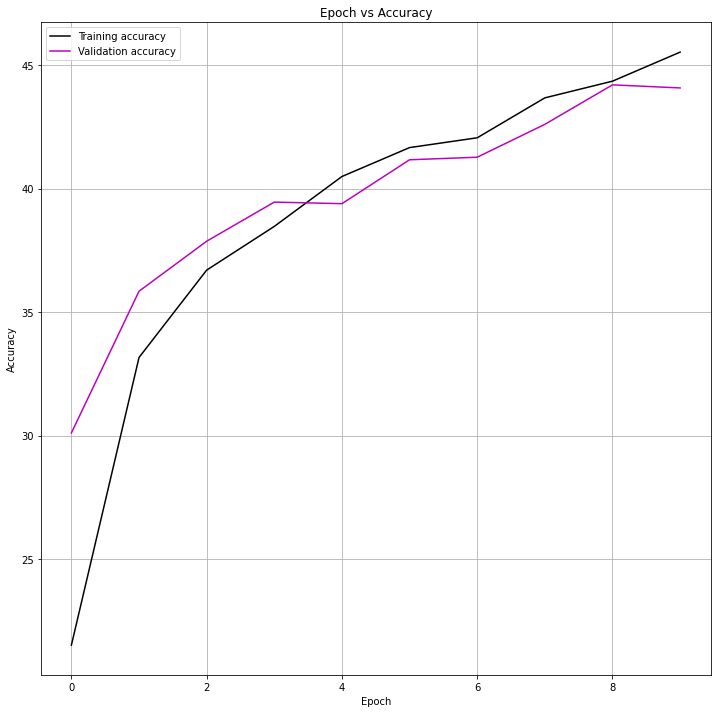



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 450.815774 sec, available: 0.000010 sec)


Accuracy:  45.14
Confusion matrix: 
 Predicted    0     1    2     3    4    5     6     7     8     9    All
Actual                                                                  
0          494    50   52    27   20   15    24    50   202    66   1000
1           38   550   12    40   22   24    35    43    77   159   1000
2           94    39  238   112  145   65   147    97    33    30   1000
3           33    41   64   367   46  151   108    81    38    71   1000
4           53    33  102    75  351   55   158   117    26    30   1000
5           23    30   75   233   59  319    92   103    43    23   1000
6           11    35   69   135   89   51   529    34     9    38   1000
7           41    46   42    65   80   61    43   521    24    77   1000
8           96    87   11    27   11   28     5    24   623    88   1000
9           47   191    8    44   10   14    34    54    76   522   1000
All        930  1102  673  1125  833  783  1175  1124  1151  1104  10000


##### Config

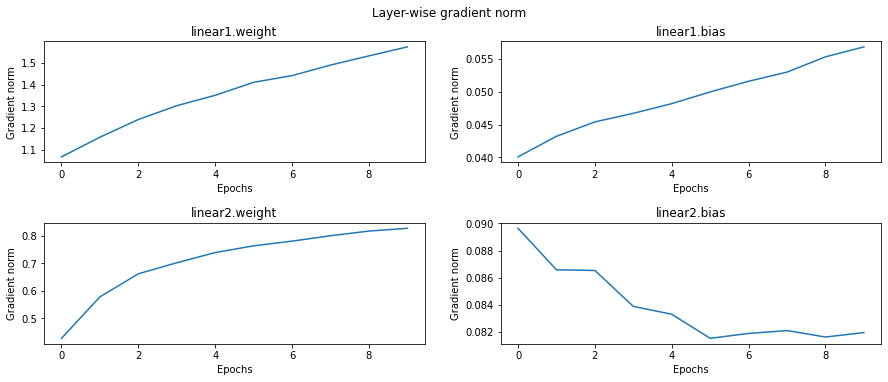

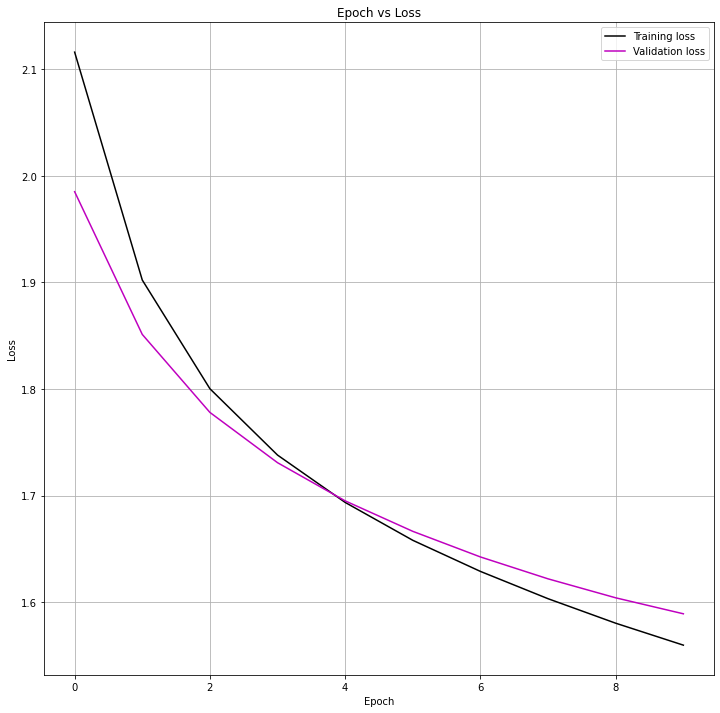

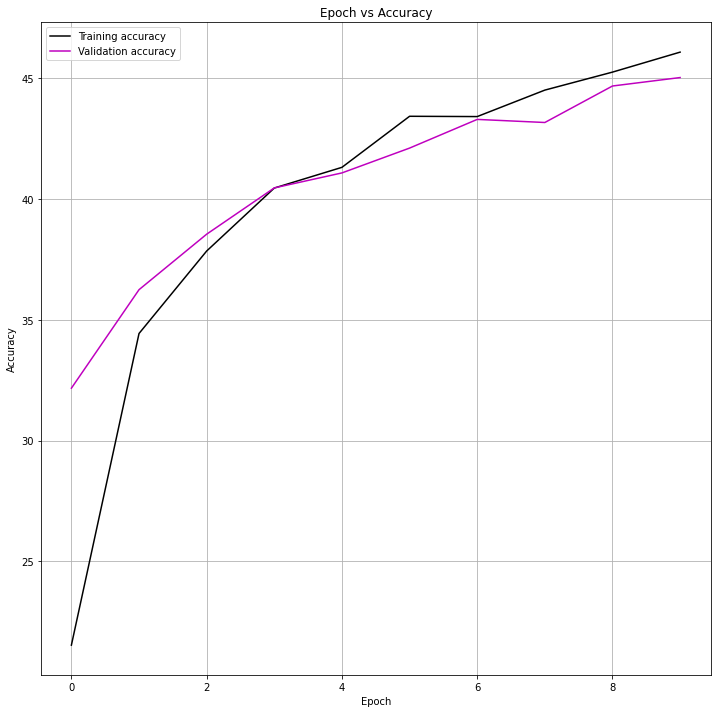



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Challenger (-45.4000) is better than incumbent (-45.3800) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate : 0.006094089305626252 -> 0.006091574530823685
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 450.573507 sec, available: 0.000010 sec)


Accuracy:  45.4
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          492    46   60   22   17   15    27    52   213    56   1000
1           35   552   17   37   16   26    38    43    87   149   1000
2           88    28  343   96   86   62   134   103    34    26   1000
3           38    47   82  333   38  164   112    81    39    66   1000
4           49    28  180   60  298   45   149   130    32    29   1000
5           25    28  103  205   47  328    88   104    42    30   1000
6           11    34   93  109   76   56   537    39    11    34   1000
7           39    34   49   64   80   69    45   520    28    72   1000
8           82    85   18   26   12   26     6    25   643    77   1000
9           40   202   15   36   10   17    36    55    95   494   1000
All        899  1084  960  988  680  808  1172  1152  1224  1033  10000


##### Configuration #####


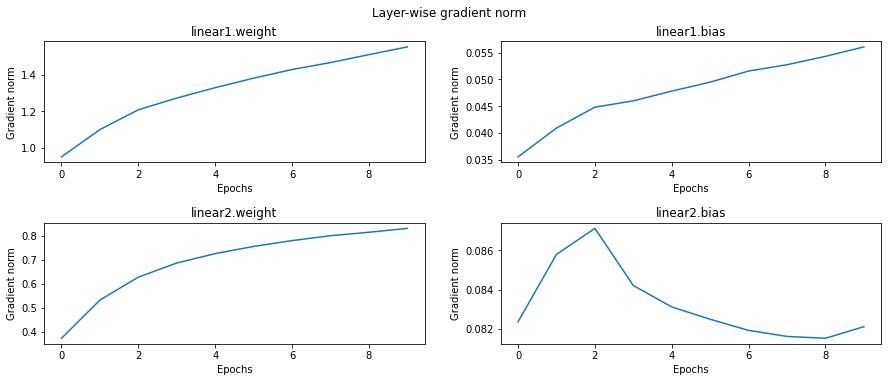

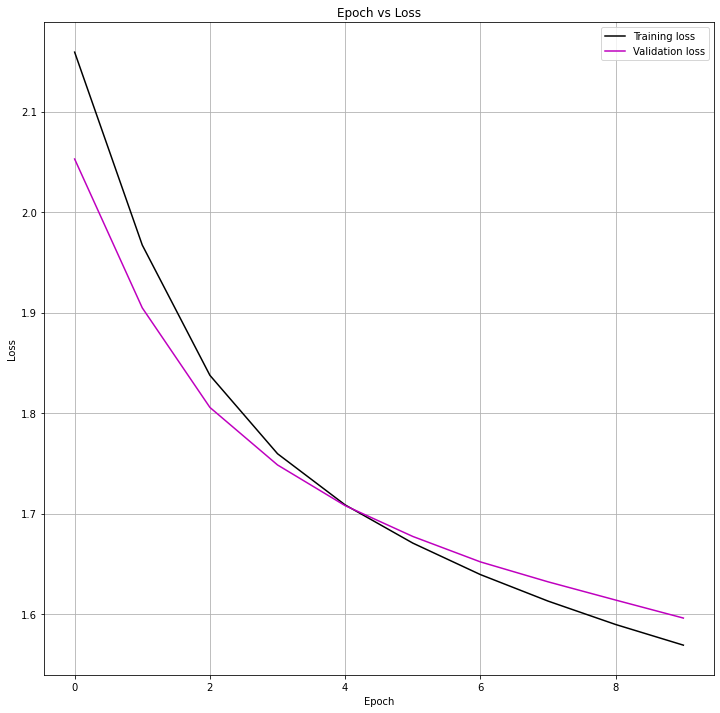

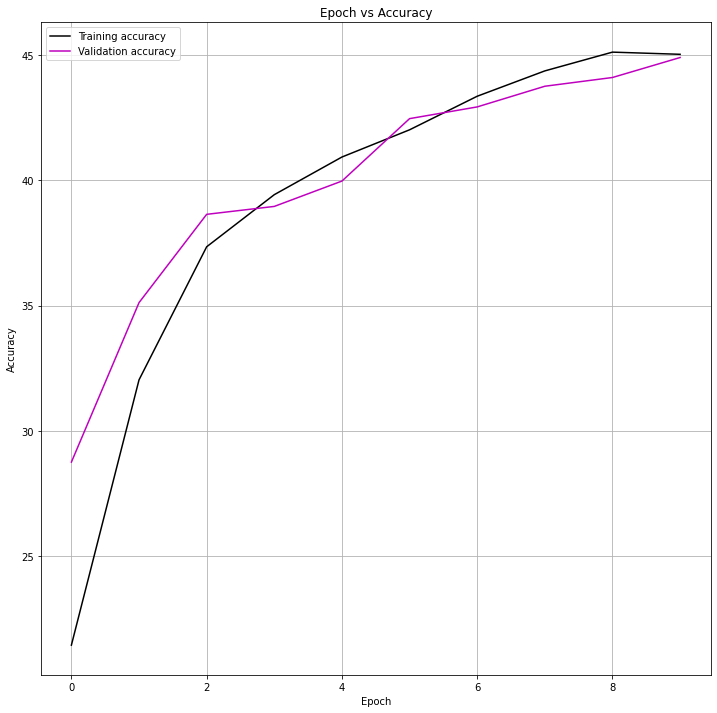



##### Evaluation module #####
Size of test data:  1250


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 455.426532 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 3
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 10 / 10.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 10 / 10.0
INFO:smac.stats.stats.Stats:#Configurations: 10
INFO:smac.stats.stats.Stats:Used wallclock time: 4577.73 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 4573.36 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  activation_function, Value: 'RELU'
  hidden_units, Value: 300
  learning_rate, Value: 0.006091574530823685

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Estimated cost of incum

Accuracy:  45.36
Confusion matrix: 
 Predicted    0     1    2     3    4    5     6     7     8     9    All
Actual                                                                  
0          510    47   55    24   23   14    32    46   185    64   1000
1           34   560   13    37   27   24    40    35    80   150   1000
2           95    30  293   106  121   65   154    82    32    22   1000
3           40    45   63   352   57  156   120    67    37    63   1000
4           52    30  130    65  346   52   163   109    26    27   1000
5           25    27   89   222   66  307   100   100    40    24   1000
6           12    33   69   118   90   48   558    31    11    30   1000
7           36    39   44    80   92   64    48   502    24    71   1000
8           99    90   14    32   15   23     6    20   610    91   1000
9           49   207   11    51   12   12    35    49    76   498   1000
All        952  1108  781  1087  849  765  1256  1041  1121  1040  10000


##### Config

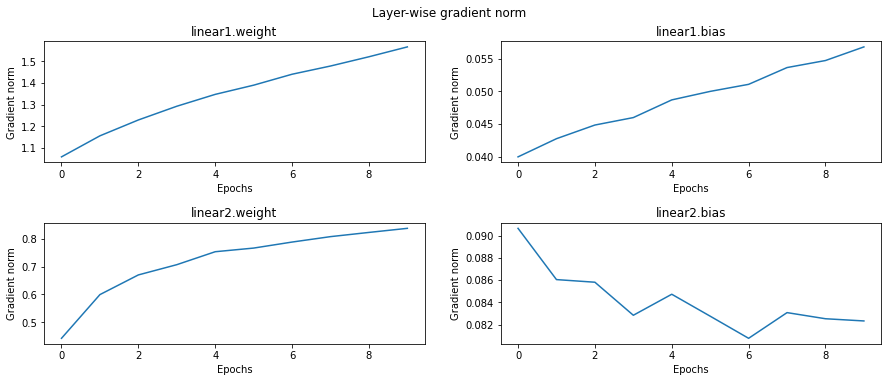

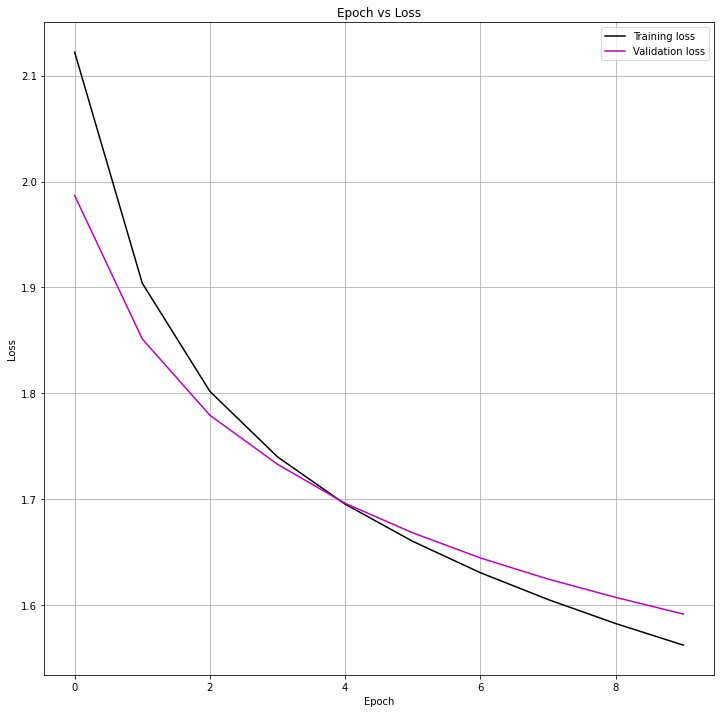

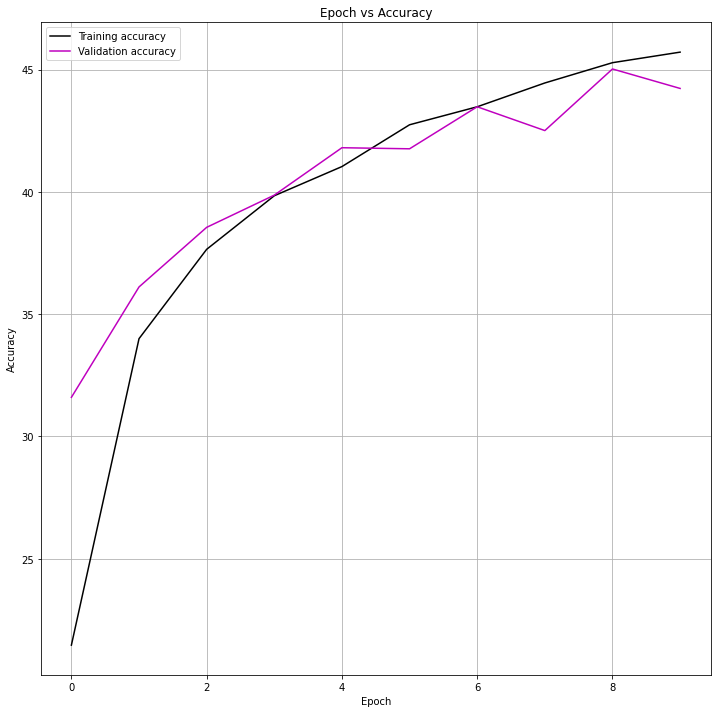



##### Evaluation module #####
Size of test data:  1250
Accuracy:  45.28
Confusion matrix: 
 Predicted    0     1    2    3    4    5     6     7     8     9    All
Actual                                                                 
0          487    57   59   22   17   15    29    44   211    59   1000
1           37   577   18   29   18   20    38    39    81   143   1000
2           89    36  341   89   93   59   149    84    35    25   1000
3           38    59   88  311   48  149   127    80    37    63   1000
4           54    34  179   55  292   51   161   119    29    26   1000
5           25    33  101  202   50  321    96   107    43    22   1000
6           10    41   86   97   75   51   564    33    13    30   1000
7           35    47   52   64   75   64    48   507    30    78   1000
8           86    84   17   24   14   29     3    21   640    82   1000
9           47   211   15   35   12   15    32    56    89   488   1000
All        908  1179  956  928  694  774  

In [21]:
def SMAC_based_HPO(configuration_space: ConfigurationSpace,
                  target_algorithm_wrapper: typing.Callable) -> typing.Tuple:
    
    """
    SMAC performing Bayersion Optimization with surrogate function as Random Forest
    
    Parameters:
    -----------
    configuration_space: ConfigurationSpace
        Configuration space with all hyperparameters of the classifier selected for HPO
    target_algorithm_wrapper: typing.Callable
        Target algorithm wrapper evaluated by the SMAC as an objective function.
        In our case, the objective function is NN performing classification on CIFAR10 dataset
        
    Return:
    -------
        incumbent: Configuration
            Best configuration found by SMAC performing Bayesian optimization
        -inc_value: float
            -ve of inc_value is the accuracy value. 
            This -ve is to negate the -ve assigned to perform minimization
    
    """

    # Scenario object
    scenario = Scenario({"run_obj": "quality",  # we optimize quality (alternatively runtime)
                         "runcount-limit": 10,  # max. number of function evaluations; for this example set to a low number
                         "cs": configuration_space,  # configuration space
                         "deterministic": "true",
                         "limit-resources": False,
                        })

    smac = SMAC4HPO(scenario=scenario,
                    rng=np.random.RandomState(42),
                    tae_runner=target_algorithm_wrapper, 
                    initial_design=DefaultConfiguration,
                   )

    # Start optimization
    try:
        incumbent = smac.optimize()
    finally:
        incumbent = smac.solver.incumbent
        
    inc_value = smac.get_tae_runner().run(incumbent, 1)[1]
    
    return incumbent, -inc_value

configuration_space = define_search_space()
best_configuration, accuracy = SMAC_based_HPO(configuration_space, run_model_from_cfg)
print('\n###########################')
print("Best configuration found by SMAC based HPO:\n", best_configuration)
print("Accuracy of the best configuration: %.2f" % accuracy)
print('###########################\n')

In [24]:
!zip -r /content/smac3-output_2020-11-27_10:21:50_138723.zip /content/smac3-output_2020-11-27_10:21:50_138723

updating: content/smac3-output_2020-11-27_10:21:50_138723/ (stored 0%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/ (stored 0%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/traj_old.csv (deflated 54%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/runhistory.json (deflated 81%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/stats.json (deflated 41%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/configspace.pcs (deflated 21%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/configspace.json (deflated 58%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/traj_aclib2.json (deflated 67%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/traj.json (deflated 69%)
updating: content/smac3-output_2020-11-27_10:21:50_138723/run_1608637542/scenario.txt (deflated 27%)
